In [1]:
pip install unidecode


Note: you may need to restart the kernel to use updated packages.


In [2]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import unidecode
import pandas as pd
from rasterstats import zonal_stats

In [4]:
# Cargar shapefile
gdf = gpd.read_file("data/DISTRITOS.shp")

# Asegurar que los nombres de columnas estén en mayúsculas
gdf.columns = [col.upper() for col in gdf.columns]

# Limpiar tildes y pasar a mayúsculas en columnas clave
for col in ["DEPARTAMEN", "PROVINCIA", "DISTRITO"]:
    gdf[col] = gdf[col].apply(lambda x: unidecode.unidecode(x.upper()))

# Renombrar la columna GEOMETRY a geometry
gdf = gdf.rename(columns={"GEOMETRY": "geometry"})

# Asegurar que es GeoDataFrame y tiene CRS correcto
gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs="EPSG:4326")

# Renombrar la columna y convertirla a string
gdf = gdf.rename(columns={"IDDIST": "UBIGEO"})
gdf["UBIGEO"] = gdf["UBIGEO"].astype(str)

# Revisar resultado
display(gdf.head())


IDDPTO DEPARTAMEN IDPROV    PROVINCIA  UBIGEO                DISTRITO  \
0     10    HUANUCO   1009  PUERTO INCA  100902         CODO DEL POZUZO   
1     10    HUANUCO   1009  PUERTO INCA  100904             TOURNAVISTA   
2     25    UCAYALI   2503   PADRE ABAD  250305  ALEXANDER VON HUMBOLDT   
3     25    UCAYALI   2503   PADRE ABAD  250302                 IRAZOLA   
4     25    UCAYALI   2503   PADRE ABAD  250304                 NESHUYA   

                  CAPITAL CODCCPP  AREA FUENTE  \
0         CODO DEL POZUZO    0001     1   INEI   
1             TOURNAVISTA    0001     1   INEI   
2  ALEXANDER VON HUMBOLDT    0001     1   INEI   
3           SAN ALEJANDRO    0001     1   INEI   
4            MONTE ALEGRE    0001     1   INEI   

                                            geometry  
0  POLYGON ((-75.31797 -9.29529, -75.31710 -9.297...  
1  POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...  
2  POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...  
3  POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...  
4  POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...

In [6]:
# Cargar el GeoTIFF
src = rasterio.open("data/tmin_raster.tif")

# Ver cuántas bandas tiene
print("Número de bandas:", src.count)

# Iterar sobre las bandas (Band 1 = 2020, Band 2 = 2021, etc.)
for i in range(1, src.count + 1):
    band = src.read(i)
    year = 2020 + (i - 1)
    print(f"Banda {i} = Año {year}, tamaño: {band.shape}")

Número de bandas: 5
Banda 1 = Año 2020, tamaño: (397, 285)
Banda 2 = Año 2021, tamaño: (397, 285)
Banda 3 = Año 2022, tamaño: (397, 285)
Banda 4 = Año 2023, tamaño: (397, 285)
Banda 5 = Año 2024, tamaño: (397, 285)


In [9]:
#Vamos a verificar si todas las bandas estan con la escala correcta

print("Valores por banda (para verificar escala):")
for i in range(1, src.count + 1):
    band = src.read(i)
    print(f"Banda {i} ({2019 + i}):")
    print(f"  Mín: {np.nanmin(band):.2f}")
    print(f"  Máx: {np.nanmax(band):.2f}")
    print("-" * 30)

#Podemos que sí, son temperaturas realistas

Valores por banda (para verificar escala):
Banda 1 (2020):
  Mín: -9.05
  Máx: 24.64
------------------------------
Banda 2 (2021):
  Mín: -10.02
  Máx: 24.39
------------------------------
Banda 3 (2022):
  Mín: -9.87
  Máx: 24.21
------------------------------
Banda 4 (2023):
  Mín: -9.06
  Máx: 24.12
------------------------------
Banda 5 (2024):
  Mín: -8.85
  Máx: 24.15
------------------------------


In [10]:
results = []

for i in range(1, src.count + 1):
    band = src.read(i, masked=True)
    year = 2019 + i  # banda 1 = 2020
    
    stats = zonal_stats(
        gdf,                  
        band,                 
        affine=src.transform,
        nodata=src.nodata,
        stats=["count", "mean", "min", "max", "std", "percentile_10", "percentile_90"],
        add_stats={"range": lambda x: np.nanmax(x) - np.nanmin(x)}
    )
    
    df_band = gdf[["UBIGEO", "DEPARTAMEN", "PROVINCIA", "DISTRITO"]].copy()
    df_band["year"] = year
    df_band["count"] = [s["count"] for s in stats]
    df_band["mean"] = [s["mean"] for s in stats]
    df_band["min"] = [s["min"] for s in stats]
    df_band["max"] = [s["max"] for s in stats]
    df_band["std"] = [s["std"] for s in stats]
    df_band["p10"] = [s["percentile_10"] for s in stats]
    df_band["p90"] = [s["percentile_90"] for s in stats]
    df_band["range"] = [s["range"] for s in stats]
    
    results.append(df_band)

zonal_stats_df = pd.concat(results, ignore_index=True)
display(zonal_stats_df.head())


c:\Users\atara\anaconda3\envs\H3\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
c:\Users\atara\anaconda3\envs\H3\Lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
c:\Users\atara\anaconda3\envs\H3\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
c:\Users\atara\anaconda3\envs\H3\Lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
c:\Users\atara\anaconda3\envs\H3\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecati

UBIGEO DEPARTAMEN    PROVINCIA                DISTRITO  year  count  \
0  100902    HUANUCO  PUERTO INCA         CODO DEL POZUZO  2020    107   
1  100904    HUANUCO  PUERTO INCA             TOURNAVISTA  2020     57   
2  250305    UCAYALI   PADRE ABAD  ALEXANDER VON HUMBOLDT  2020      6   
3  250302    UCAYALI   PADRE ABAD                 IRAZOLA  2020     62   
4  250304    UCAYALI   PADRE ABAD                 NESHUYA  2020     22   

        mean        min        max       std        p10        p90      range  
0  18.932154   8.903979  22.604116  3.430219  13.836891  22.358987  13.700137  
1  22.290649  19.775057  22.860834  0.464426  21.992695  22.676195   3.085777  
2  22.056366  21.953405  22.141968  0.076649  21.955791  22.137794   0.188562  
3  22.263211  21.661476  22.481043  0.158932  22.042723  22.416751   0.819567  
4  22.173068  21.975763  22.385101  0.118299  22.023389  22.361992   0.409338

In [11]:
# Guardar resultados en CSV
zonal_stats_df.to_csv("data/estadisticas_tmin.csv", index=False, encoding="utf-8")

print("✅ Archivo guardado en: data/estadisticas_tmin.csv")


✅ Archivo guardado en: data/estadisticas_tmin.csv


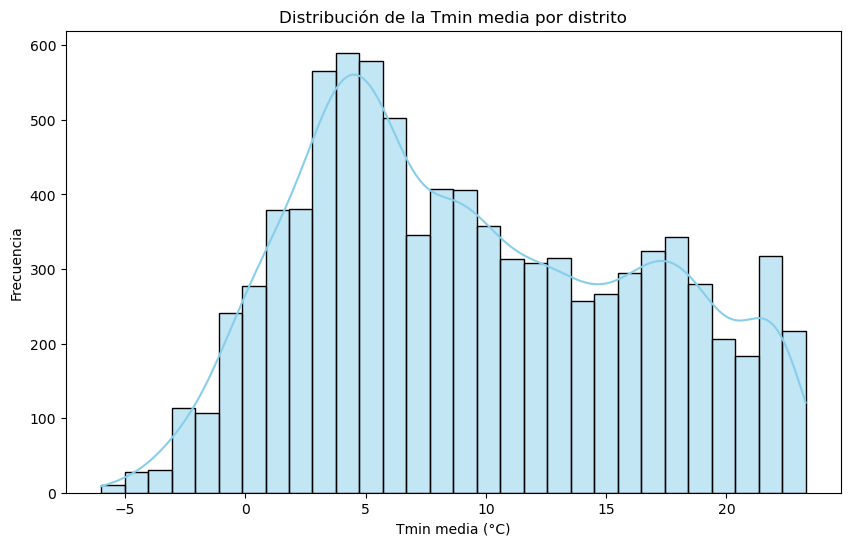

In [16]:
#3.3 Analysis & Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# --- Distribución: histograma/KDE de la media Tmin a nivel distrito ---
plt.figure(figsize=(10,6))
sns.histplot(zonal_stats_df["mean"], kde=True, bins=30, color="skyblue")
plt.title("Distribución de la Tmin media por distrito")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Frecuencia")
plt.savefig("notebooks/figures_distribucion_tmin.png", dpi=300)
plt.show()

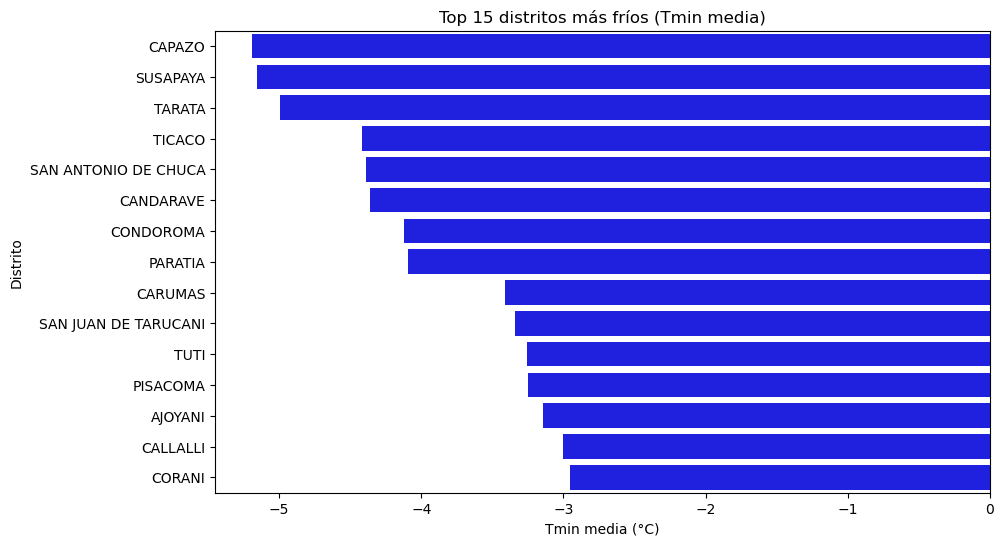

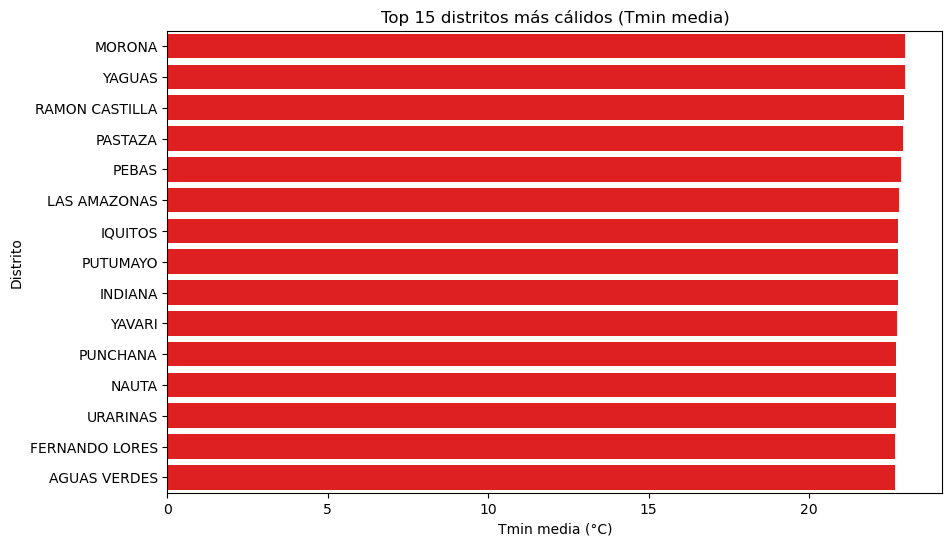

In [22]:
# --- Clasificación: top 15 más fríos y más cálidos ---
# Eliminar filas con NaN en 'mean'
df_mean = (
    zonal_stats_df.dropna(subset=["mean"])  # <- muy importante
    .groupby("DISTRITO")["mean"]
    .mean()
    .reset_index()
)

# Top 15 más fríos
top15_cold = df_mean.nsmallest(15, "mean")
# Top 15 más cálidos
top15_hot = df_mean.nlargest(15, "mean")

# Guardar tablas
top15_cold.to_csv("notebooks/top15_cold.csv", index=False)
top15_hot.to_csv("notebooks/top15_hot.csv", index=False)

# Plot ranking
plt.figure(figsize=(10,6))
sns.barplot(data=top15_cold, x="mean", y="DISTRITO", color="blue")
plt.title("Top 15 distritos más fríos (Tmin media)")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Distrito")
plt.savefig("notebooks/figures_top15_cold.png", dpi=300)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=top15_hot, x="mean", y="DISTRITO", color="red")
plt.title("Top 15 distritos más cálidos (Tmin media)")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Distrito")
plt.savefig("notebooks/figures_top15_hot.png", dpi=300)
plt.show()

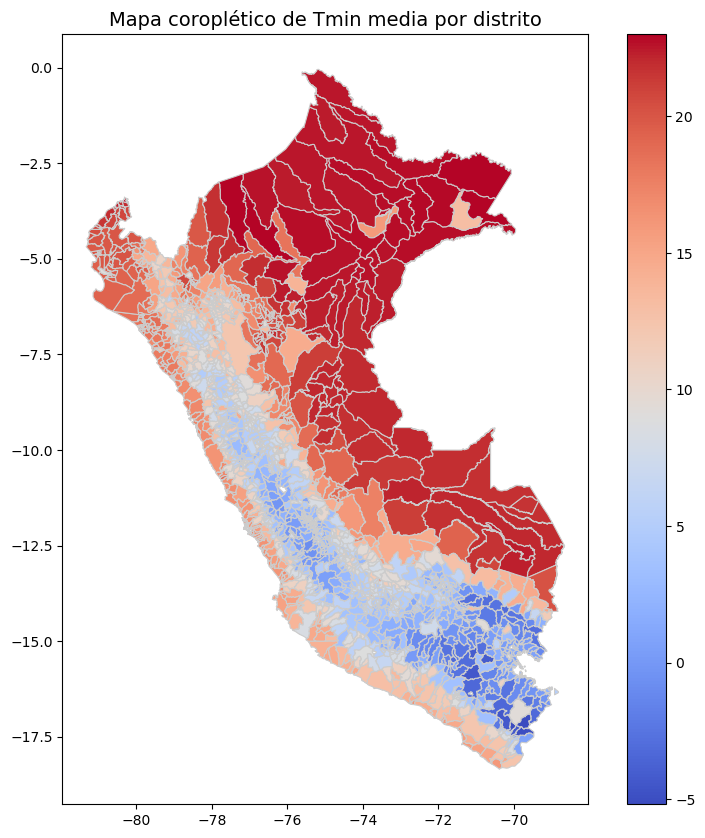

In [23]:
# --- Mapa coroplético ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_plot = gdf.merge(df_mean, on="DISTRITO", how="left")
gdf_plot.plot(
    column="mean",
    cmap="coolwarm",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    ax=ax
)
ax.set_title("Mapa coroplético de Tmin media por distrito", fontsize=14)
plt.savefig("notebooks/figures_mapa_tmin.png", dpi=300)
plt.show()


In [24]:
#  Public policy (guide) -- Text

with open("notebooks/politicas_publicas.md", "w", encoding="utf-8") as f:
    f.write("""# 3.4 Políticas Públicas

## Heladas altoandinas
- **Objetivo**: Reducir casos de IRA y pérdidas agrícolas.
- **Población objetivo**: Distritos con Tmin ≤ p10 en Puno, Cusco, Ayacucho, Huancavelica, Pasco.
- **Intervención**: Viviendas térmicas (ISUR), kits antiheladas, refugios para ganado.
- **Costo estimado**: S/ 2,500 por hogar.
- **KPI**: −15% casos IRA (MINSA), −20% mortalidad de alpacas, +10% asistencia escolar.

## Oleadas de frío amazónico
- **Objetivo**: Reducir enfermedades respiratorias y días escolares perdidos.
- **Población objetivo**: Loreto, Ucayali, Madre de Dios (≤ Tmin p10).
- **Intervención**: Escuelas climatizadas, campañas de salud, distribución de ropa de abrigo.
- **Costo estimado**: S/ 80,000 por escuela.
- **KPI**: −10% hospitalizaciones por IRA, +5% asistencia escolar.
""")